# Analysis of Annif suggestions in repositories

## Install and import packages
In VS Code the simplest way to install packages in correct venv is to do it in the notebook.

In [1]:
! pip install --upgrade pip setuptools wheel
! pip install ndjson pandas rdflib matplotlib jinja2

import ndjson
import pandas as pd
import numpy as np
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import matplotlib
import datetime

In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))

Number of triples in YSA:  433048
Number of triples in Allärs:  412097


In [3]:
# load YSO and YSO Places
yso = Graph()
yso.parse("../Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Number of triples in YSO+YSO Places:  925085


# Helper functions

In [6]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54

    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        # print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            #print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            #print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []


def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df, ax=None):
    calc_scores(df)

    # mark annif_updates in the plot
    for upd in annif_updates:
        plt.axvline(upd, color='red', linestyle='--')

    # plot precision, recall, f1 as a function of time. Label with month start
    df_monthly = df[['precision', 'recall', 'f1 score', 'date_accessioned']].set_index("date_accessioned").resample('MS').mean()
    df_monthly.plot(marker='o', ax=ax or plt.gca())
    # labels = [x.strftime("%Y-%m") for x in df_monthly.index]
    # plt.gca().set_xticklabels(labels, rotation=45)
    # plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.grid()


def plot_counts(df):
    # How many records there are with suggestions each month? Label with month start
    df_monthly = df.set_index('date_accessioned').resample("MS").id.count()
    # df_monthly.plot.bar()
    plt.bar(df_monthly.index, df_monthly, width=20)
    # plt.ylabel("Number of records")
    plt.grid()


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))


def retain_relevant(df):
    df = df.copy()
    # return df[df.suggestions.apply(lambda x: x != []) & df.subjects_uris.apply(lambda x: x != [])]
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Dates when Annif models were updated in Finto AI
annif_updates = [
    "2020-03-26",
    "2020-12-09",
    "2021-04-27",
    "2021-11-11",
    "2022-06-21",
    "2022-11-22",
    "2023-06-06",
    "2023-09-04",
    "2024-05-02",
    "2025-03-18",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


## Load data

In [7]:
from glob import glob
import os

fnames = glob("collection/*.ndjson")


def read_to_dataframe(fname):
    with open(fname) as f:
        data = ndjson.load(f)
    df = pd.DataFrame(data)

    df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
    df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")
    df['annif_update'] = df.date_accessioned.map(get_annif_update)
    df.rename(columns={'lang': 'language'}, inplace=True)
    return df

df = pd.DataFrame()
for fname in fnames:
    basename = os.path.basename(fname)
    reponame = os.path.splitext(basename)[0]
    if basename == "publications.ndjson":
        reponame = "kaisu"

    dftmp = read_to_dataframe(fname)
    dftmp['repository'] = reponame
    print(reponame, len(dftmp))
    # Append to the main dataframe
    df = pd.concat([df, dftmp], ignore_index=True)

df.head()

/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


osuva 15292


/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


kaisu 11693


/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


lauda 6652


/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


theseus 303724


/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


taju 5606


/tmp/ipykernel_1919297/4194125858.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='ignore', utc=True, format="mixed")


trepo 85524


,title,id,language,type,type_level,faculty,discipline,degreeprogram,date_accessioned,date_issued,suggestions,subjects_yso,subjects_none,subjects_all,annif_update,repository
0,Stock Return and Volatility: An empirical stud...,http://osuva.uwasa.fi/handle/10024/6527,,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Kauppatieteellinen tiedekunta|en=Faculty of...,,,2002-01-25 00:00:00+00:00,2001-01-01 00:00:00+00:00,[],[],"[heteroscedasticity, autocorrelation, volatili...","[heteroscedasticity, autocorrelation, volatili...",NaT,osuva
1,Organisaatioviestintä jääkiekkoerotuomarien to...,http://osuva.uwasa.fi/handle/10024/6125,,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Kauppatieteellinen tiedekunta|en=Faculty of...,,,2002-02-06 00:00:00+00:00,2002-01-01 00:00:00+00:00,[],[],"[Avainsanat: organisaatioviestintä, sisäinen ...","[Avainsanat: organisaatioviestintä, sisäinen ...",NaT,osuva
2,"Organisaation sisäinen viestintä, viestintäkan...",http://osuva.uwasa.fi/handle/10024/465,,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Kauppatieteellinen tiedekunta|en=Faculty of...,,,2002-02-06 00:00:00+00:00,2002-01-01 00:00:00+00:00,[],[],"[sisäinen viestintä, organisaatio, kanavat]","[sisäinen viestintä, organisaatio, kanavat, fi...",NaT,osuva
3,Mainosten matkapuhelin suomalaisen arvomaailma...,http://osuva.uwasa.fi/handle/10024/6256,,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Humanistinen tiedekunta|en=Faculty of Human...,,,2002-02-07 00:00:00+00:00,2002-01-01 00:00:00+00:00,[],[],"[arvot, mainonta, matkapuhelin, retoriikka]","[arvot, mainonta, matkapuhelin, retoriikka, fi...",NaT,osuva
4,Vähennysoikeuden rajoitukset arvonlisäverotuks...,http://osuva.uwasa.fi/handle/10024/4842,,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Pro gradu - tutkielma |en=Master's thesis|s...,fi=Kauppatieteellinen tiedekunta|en=Faculty of...,,,2002-02-07 00:00:00+00:00,2002-01-01 00:00:00+00:00,[],[],"[vähennysoikeuden rajoitukset, arvonlisäverotus]","[vähennysoikeuden rajoitukset, arvonlisäverotu...",NaT,osuva


In [8]:
max_date = "2025-04-01"
min_date = "2020-09-01"
df = df[(df.date_accessioned >= min_date) & (df.date_accessioned < max_date)]
len(df)

168530

In [9]:
df.drop(columns=['date_issued', 'subjects_none'], inplace=True)  # remove unneeded columns to free up memory
len(df)

168530

In [10]:
df.groupby('repository').size()  # Lauda and Taju have so few records that it is not worth debugging why they have no useful data

repository
kaisu        2601
lauda        2006
osuva        5419
taju         1388
theseus    118657
trepo       38459
dtype: int64

In [11]:
# Show all lines in the dataframe
pd.set_option('display.max_rows', None)
df.groupby('language').size().sort_values(ascending=False).head(20)

language
fin    96844
en     22498
eng    21806
fi     21688
swe     3512
sv       553
FIN      522
         355
ENG      291
ru       136
de       104
SWE       89
es        30
fr        23
mul       12
deu       11
pt         8
it         7
ger        6
rus        5
dtype: int64

In [12]:
# Map language codes to ISO 639-1
lang_map = {
    'fi': 'fi',
    'fin': 'fi',
    'FIN': 'fi',
    'sv': 'sv',
    'swe': 'sv',
    'SWE': 'sv',
    'en': 'en',
    'eng': 'en',
    'ENG': 'en',
}
def map_language_code(code):
    if code in lang_map:
        return lang_map[code]
    else:
        return code

df['language'] = df['language'].apply(map_language_code)

# Remove rows with unknown language codes
df = df[df['language'].isin(lang_map.values())]
len(df)

167803

In [13]:
df.groupby('language').size().sort_values(ascending=False).head(20)

language
fi    119054
en     44595
sv      4154
dtype: int64

In [14]:
# Simply get uris from YSO by label
df_with_uris = pd.concat([
    add_subjects_uris(df[df.language == 'en'], 'en', source_col='subjects_all'),
    add_subjects_uris(df[df.language == 'sv'], 'sv', source_col='subjects_all'),
    add_subjects_uris(df[df.language == 'fi'], 'fi', source_col='subjects_all')
])
len(df_with_uris)

/tmp/ipykernel_1919297/161582590.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_1919297/161582590.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
/tmp/ipykernel_1919297/161582590.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

167803

In [29]:
# in Lauda and Taju there are no suggestions
! grep 'suggestions": \["\w' collection/{lauda,taju}.ndjson | wc -l
! grep 'suggestions": \["\w' collection/osuva.ndjson | wc -l

0
5845


In [ ]:
get_number_of_rows(df_with_uris)
# Retain only rows having both suggestions and subjects_uris
df_relevant = retain_relevant(df_with_uris)
print("After retaining relevant rows")
print(len(df_relevant))
print(df_relevant.repository.unique())


df_relevant.groupby("repository").size().sort_values(ascending=False).round(-3)

rows:  167803
rows with subjects_yso:  134354
rows with subjects_all:  165794
rows with suggestions:  167803
rows with subjects_uris:  137848
rows with both suggestions & subject_uris:  125714
After retaining relevant rows
125714
['osuva' 'kaisu' 'theseus' 'trepo']


repository
theseus    107000
trepo       14000
osuva        4000
kaisu        1000
dtype: int64

## Main results: precision, recall, and f1 over time

/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


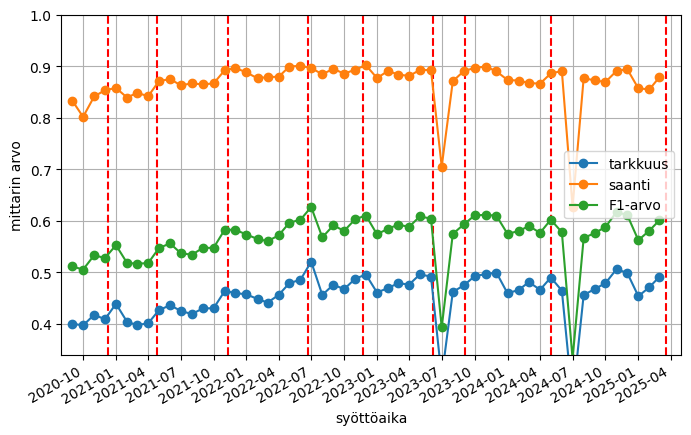

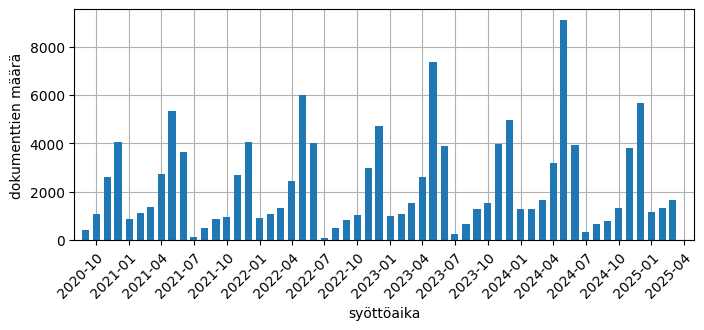

In [49]:
plt.figure(figsize=(8, 5))
plot_scores(df_relevant)
plt.xlabel("syöttöaika")
plt.ylabel("mittarin arvo")
# set start of time range to 2020-09-01
xlims = (datetime.datetime(2020, 8, 1, tzinfo=datetime.timezone.utc), datetime.datetime(2025, 5, 1, tzinfo=datetime.timezone.utc))
plt.xlim(xlims)
plt.ylim(0.34, 1)

# hide legend labels of vertical lines and change other labels to finnish
# 1. get the plot's handles and labels:
h, l = plt.gca().get_legend_handles_labels()
# 2. slice off the first items in the list:
plt.gca().legend(
    handles=[hi for hi in h[-3:]],
    labels=["tarkkuus", "saanti", "F1-arvo"],
    loc='center right')
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", max_date, freq="3MS"))
plt.gca().set_xlim(xlims)
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.savefig('kuva-1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(8, 3))
plot_counts(df_relevant)
plt.xlabel("syöttöaika")
plt.ylabel("dokumenttien määrä")
plt.yticks([0, 2000, 4000, 6000, 8000])
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", max_date, freq="3MS"))
plt.gca().set_xlim(xlims)
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
# rotate x tick labels
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.gca().set_axisbelow(True)
plt.savefig('kuva-2.svg', format='svg', bbox_inches='tight')


osuva


/tmp/ipykernel_1919297/161582590.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582590.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582

kaisu


/tmp/ipykernel_1919297/161582590.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582590.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582

theseus


/tmp/ipykernel_1919297/161582590.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582590.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582

trepo


/tmp/ipykernel_1919297/161582590.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582590.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
/tmp/ipykernel_1919297/161582

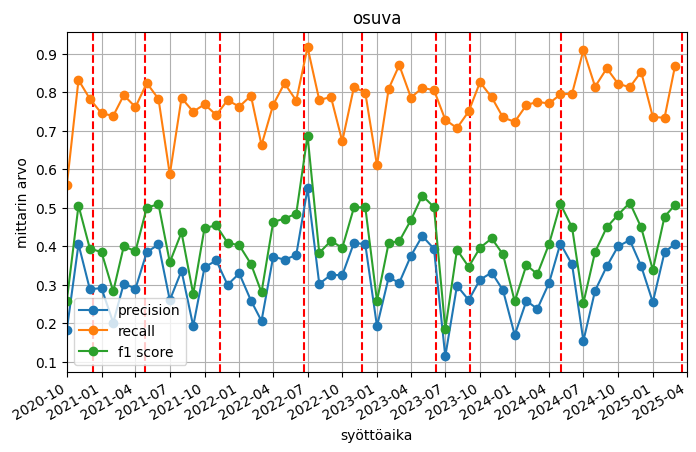

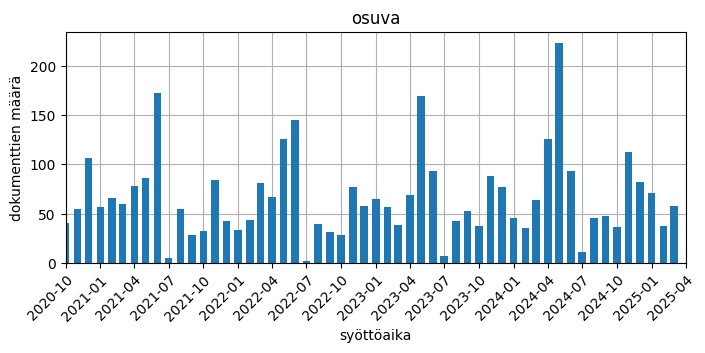

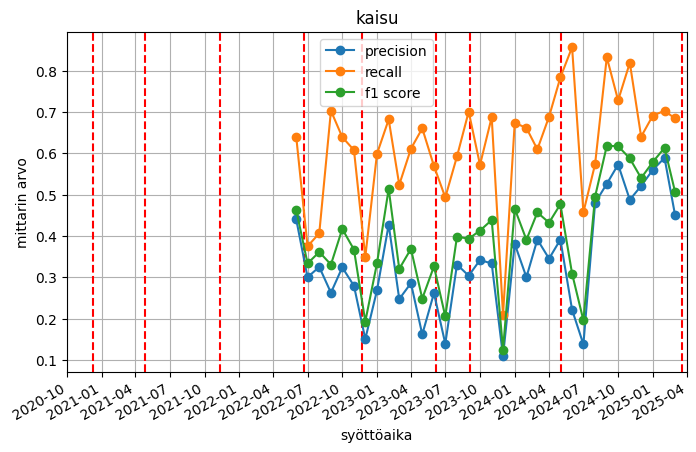

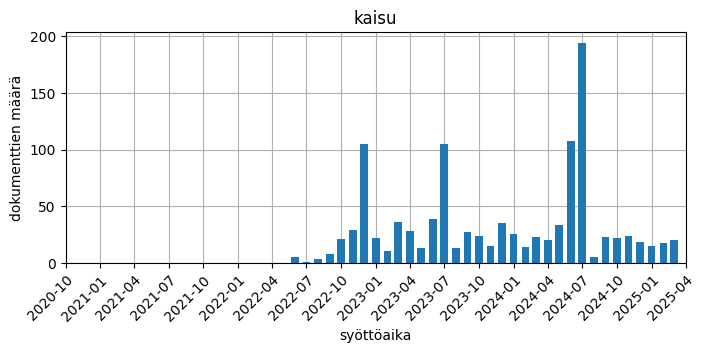

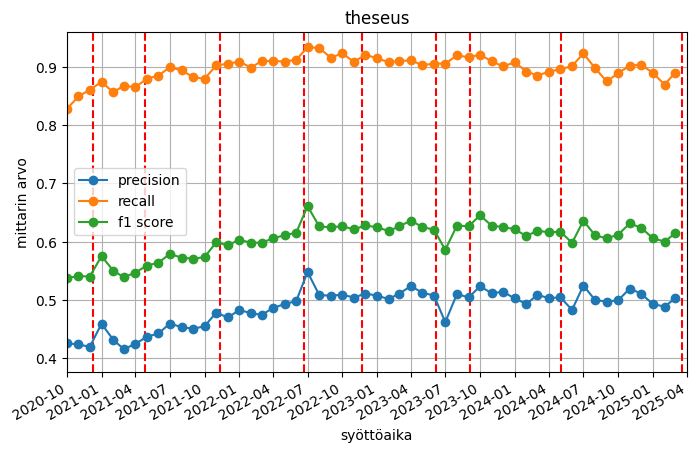

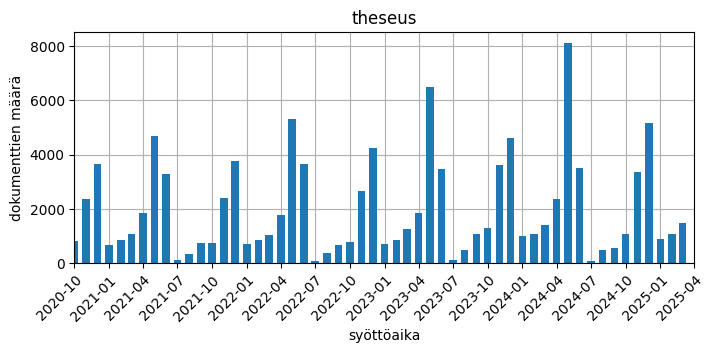

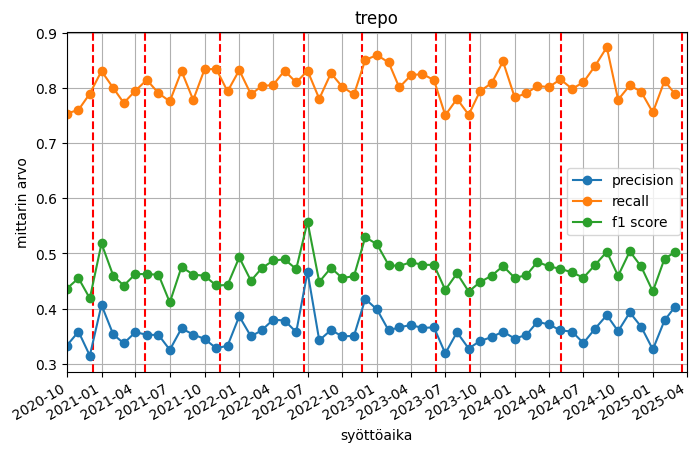

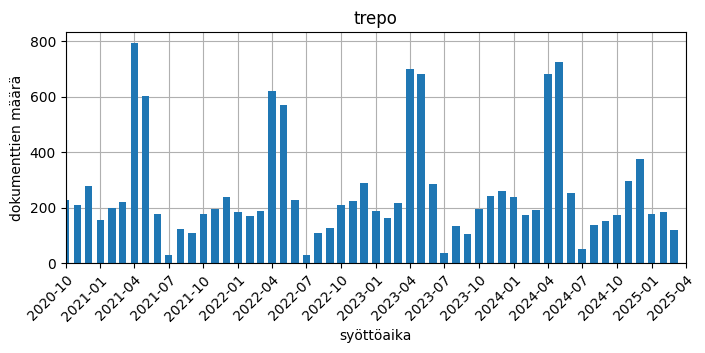

In [18]:
# Plot for each repository in subplots

for ind, reponame in enumerate(df_relevant.repository.unique()):
    print(reponame)
    df_repo = df_relevant[df_relevant.repository == reponame]

    plt.figure(figsize=(8, 5))
    plot_scores(df_repo)
    plt.xlabel("syöttöaika")
    plt.ylabel("mittarin arvo")
    # set start of time range to 2020-09-01
    plt.xlim(datetime.datetime(2020, 8, 1, tzinfo=datetime.timezone.utc))
    plt.title(reponame)

    # hide legend labels of vertical lines and change other labels to finnish
    # plt.legend(["_"]*len(annif_updates) + ["tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
    # set x ticks to every 3 months starting from 2020-10, ticks to start of month
    plt.gca().set_xticks(pd.date_range("2020-10-01", max_date, freq="3MS"))
    plt.gca().set_xlim([datetime.date(2020, 10, 1), datetime.datetime.strptime(max_date, "%Y-%m-%d").date()])
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    # plt.savefig('kuva-1.svg', format='svg', bbox_inches='tight')

    plt.figure(figsize=(8, 3))
    plot_counts(df_repo)
    plt.xlabel("syöttöaika")
    plt.ylabel("dokumenttien määrä")
    # plt.yticks([0, 2000, 4000, 6000])
    # set x ticks to every 3 months starting from 2020-10, ticks to start of month
    plt.gca().set_xticks(pd.date_range("2020-10-01", max_date, freq="3MS"))
    plt.gca().set_xlim([datetime.date(2020, 10, 1), datetime.datetime.strptime(max_date, "%Y-%m-%d").date()])
    # format x ticks to month-year
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    # rotate x tick labels
    _ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.gca().set_axisbelow(True)
    plt.title(reponame)
    # plt.savefig('kuva-2.svg', format='svg', bbox_inches='tight')

In [ ]:
# Group by repo and give mean precision, recall, f1, and size of each group
pd.concat(
    (df_relevant.groupby("repository")[['precision', 'recall', 'f1 score']].mean().round(2),
    df_relevant.groupby("repository")[['precision', 'recall', 'f1 score']].size().rename('size')), axis=1)



,precision,recall,f1 score,size
repository,,,,
kaisu,0.26,0.58,0.33,1106
osuva,0.34,0.78,0.43,3637
theseus,0.49,0.90,0.60,107093
trepo,0.36,0.81,0.47,13878


In [58]:
# Group by language and give mean precision, recall, f1
pd.concat(
    (df_relevant.groupby("language")[['precision', 'recall', 'f1 score']].mean().round(2),
    df_relevant.groupby("language")[['precision', 'recall', 'f1 score']].size().rename('size')), axis=1)


,precision,recall,f1 score,size
language,,,,
en,0.45,0.88,0.56,19908
fi,0.47,0.88,0.59,102521
sv,0.49,0.90,0.60,3285


In [59]:
# Group by annif_update and give mean precision, recall, f1
pd.concat(
    (df_relevant.groupby("annif_update")[['precision', 'recall', 'f1 score']].mean().round(2),
    df_relevant.groupby("annif_update")[['precision', 'recall', 'f1 score']].size().rename('size')), axis=1)

,precision,recall,f1 score,size
annif_update,,,,
2020-03-26 00:00:00+00:00,0.41,0.84,0.52,5704
2020-12-09 00:00:00+00:00,0.41,0.85,0.53,7571
2021-04-27 00:00:00+00:00,0.43,0.87,0.55,12960
2021-11-11 00:00:00+00:00,0.47,0.89,0.59,21676
2022-06-21 00:00:00+00:00,0.48,0.89,0.59,4163
2022-11-22 00:00:00+00:00,0.49,0.89,0.60,21363
2023-06-06 00:00:00+00:00,0.47,0.88,0.58,3382
2023-09-04 00:00:00+00:00,0.48,0.88,0.60,19183
2024-05-02 00:00:00+00:00,0.48,0.88,0.59,28860


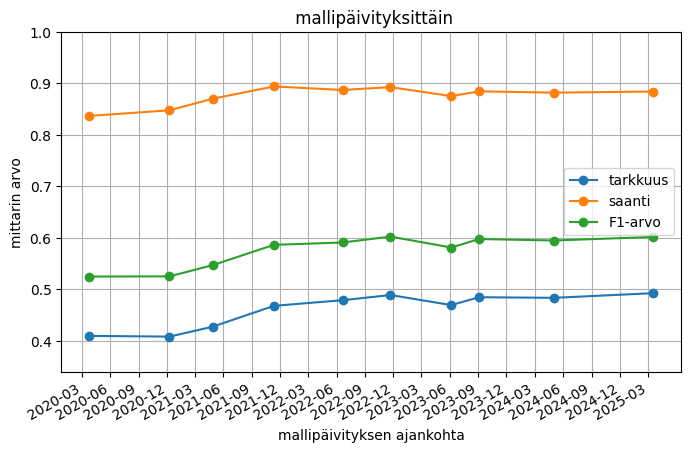

In [79]:

# Group by annif_update and plot mean precision, recall, f1
df_relevant.groupby("annif_update")[['precision', 'recall', 'f1 score']].agg(['mean']).plot(marker='o', figsize=(8, 5))
plt.grid()
plt.title(" mallipäivityksittäin")
plt.xlabel("mallipäivityksen ajankohta")
plt.ylabel("mittarin arvo")
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-03-01", max_date, freq="3MS"))
# plt.gca().set_xlim(xlims)
plt.gca().set_ylim(0.34, 1)
# hide legend labels of vertical lines and change other labels to finnish
# 1. get the plot's handles and labels:
h, l = plt.gca().get_legend_handles_labels()
# 2. slice off the first items in the list:
plt.gca().legend(
    handles=[hi for hi in h[-3:]],
    labels=["tarkkuus", "saanti", "F1-arvo"],
    loc='center right')
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))

In [85]:
df_tmp = pd.concat(
    (df_relevant.groupby("type")[['precision', 'recall', 'f1 score']].mean().round(2),
    df_relevant.groupby("type")[['precision', 'recall', 'f1 score']].size().rename('size')), axis=1)
# filter out groups that have less than 100 records
df_tmp[df_tmp['size'] > 100].sort_values(by='f1 score', ascending=False)

,precision,recall,f1 score,size
type,,,,
fi=Publisher's version|sv=Publisher's version|en=Publisher's version|,0.77,0.93,0.83,105
fi=Ylempi AMK-opinnäytetyö|sv=Högre YH-examensarbete|en=Master's thesis|,0.50,0.89,0.61,18927
publication,0.53,0.84,0.61,1597
fi=AMK-opinnäytetyö|sv=YH-examensarbete|en=Bachelor's thesis|,0.49,0.90,0.60,86369
fi=Pro gradu -tutkielma|en=Master's thesis|sv=Pro gradu -avhandling|,0.43,0.81,0.54,2075
publishedVersion,0.44,0.78,0.53,269
fi=Diplomityö|en=Master's thesis (M.Sc. (Tech.))|sv=Diplomarbete|,0.39,0.80,0.50,131
fi= Pro gradu -tutkielma | en=Master's thesis|,0.39,0.80,0.49,4425
fi= Kandidaatintyö | en=Bachelor's thesis|,0.37,0.83,0.48,5995


In [86]:
df_kaisu = df_relevant[df_relevant.repository == "kaisu"]
df_kaisu.sort_values(by="f1 score", ascending=True).head()

,title,id,language,type,type_level,faculty,discipline,degreeprogram,date_accessioned,suggestions,subjects_yso,subjects_all,annif_update,repository,subjects_uris,precision,recall,f1 score
24875,Assessing transition risks in banks’ corporate...,https://publications.bof.fi/handle/10024/52598,en,Journal Article,,,,,2023-01-26 11:57:05+00:00,"[http://www.yso.fi/onto/yso/p437, http://www.y...","[ilmastonmuutokset, hiilineutraalius, pankit, ...","[yritysluotot, kestävä rahoitus, carbon neutra...",2022-11-22 00:00:00+00:00,kaisu,[http://www.yso.fi/onto/yso/p21899],0.0,0.0,0.0
26747,Pankkivaltuusmiesten pöytäkirja 2.7.1924,https://publications.bof.fi/handle/10024/53216,fi,Archival material,,,,,2023-12-18 07:37:41+00:00,"[http://www.yso.fi/onto/yso/p1780, http://www....",[],"[pankkivaltuusmiehet, 1924, pöytäkirjat, valuu...",2023-09-04 00:00:00+00:00,kaisu,[http://www.yso.fi/onto/yso/p2576],0.0,0.0,0.0
26790,Pankkivaltuusmiesten pöytäkirja 26.8.1924,https://publications.bof.fi/handle/10024/53218,fi,Archival material,,,,,2023-12-18 08:18:49+00:00,"[http://www.yso.fi/onto/yso/p1780, http://www....",[],"[pankkivaltuusmiehet, 1924, pöytäkirjat, kuuka...",2023-09-04 00:00:00+00:00,kaisu,[http://www.yso.fi/onto/yso/p2576],0.0,0.0,0.0
26809,Pankkivaltuusmiesten pöytäkirja 26.9.1924,https://publications.bof.fi/handle/10024/53219,fi,Archival material,,,,,2023-12-18 08:27:33+00:00,"[http://www.yso.fi/onto/yso/p1780, http://www....",[],"[pankkivaltuusmiehet, 1924, pöytäkirjat, valuu...",2023-09-04 00:00:00+00:00,kaisu,[http://www.yso.fi/onto/yso/p2576],0.0,0.0,0.0
26768,Investointien maksutasevaikutusten mittaaminen,https://publications.bof.fi/handle/10024/53563,fi,Paper,,,,,2024-06-24 15:34:43+00:00,"[http://www.yso.fi/onto/yso/p94470, http://www...","[investoinnit, maksutase, mittaus]","[Suomi, investoinnit, maksutase, mittaus]",2024-05-02 00:00:00+00:00,kaisu,"[http://www.yso.fi/onto/yso/p94426, http://www...",0.0,0.0,0.0


In [88]:
pd.concat(
    (df_kaisu.groupby("type")[['precision', 'recall', 'f1 score']].mean().round(2),
    df_kaisu.groupby("type")[['precision', 'recall', 'f1 score']].size().rename('size')), axis=1).sort_values(by='f1 score', ascending=False)

,precision,recall,f1 score,size
type,,,,
Journal,0.48,0.68,0.53,36
Journal Article,0.40,0.66,0.47,342
Newsletter,0.35,0.79,0.47,6
Paper,0.23,0.70,0.31,361
Journal article,0.20,0.40,0.27,2
Report,0.15,0.41,0.20,318
Archival material,0.08,0.17,0.10,39
Speech,0.00,0.00,0.00,2
